In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
print(tf.__version__)

2.6.0


In [7]:
# get dataset 
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 26s 0us/step


In [8]:
# preprocessing
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
# Get training data (50-50 split for traing and testing than 80-20 split for training and validiation)
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)
'''
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])
'''
raw_train_ds.class_names[0]

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-07-08 11:27:52.525044: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [10]:
# preparing dataset
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

max_features = 10000
sequence_length = 250

# Standardize, Tokenize, and Vectorize data
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Get rid of labels from training data 
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text) 

# Vectorize the test
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

# convert integer mapping back to words 
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

2022-07-08 11:28:00.658988: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [11]:
# Apply preprocessing layer to all datasets 
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
for 

In [23]:
# Performance enhancement
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
# Model
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

# Compile 
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

In [27]:
# Train 
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

'''
Notes: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping 
Early stop on model training to prevent overfitting 
'''

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6635 - binary_accuracy: 0.6941 - val_loss: 0.6138 - val_binary_accuracy: 0.7742
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5469 - binary_accuracy: 0.8013 - val_loss: 0.4970 - val_binary_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4425 - binary_accuracy: 0.8446 - val_loss: 0.4191 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3766 - binary_accuracy: 0.8668 - val_loss: 0.3728 - val_binary_accuracy: 0.8622
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3343 - binary_accuracy: 0.8801 - val_loss: 0.3442 - val_binary_accuracy: 0.8692
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3038 - binary_accuracy: 0.8896 - val_loss: 0.3256 - val_binary_accuracy: 0.8736
Epoch 7/10
625/625 [==============================] - 1s 2ms/ste

In [28]:
# Evaluation
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3105 - binary_accuracy: 0.8735
Loss:  0.31047677993774414
Accuracy:  0.8734800219535828


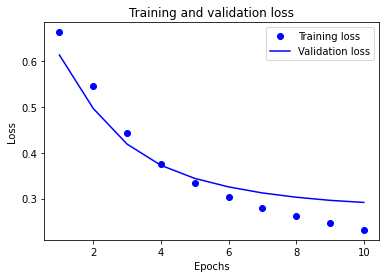

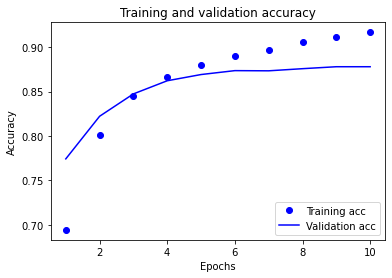

In [32]:
# Plotting
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [33]:
# Export the model 
export_model = tf.keras.Sequential([ # combining preprocessing and traing layers 
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3105 - accuracy: 0.8735
0.8734800219535828


In [61]:
# Inference on new data with export model 
examples = [
    "the movie was great!",
    "Jul 2, 2022. Along comes a film like Top Gun: Maverick (a film which the release was delayed a couple of times) and it reminds us of the good ole days in several ways. Thank you Joseph Kosinski (Oblivion, Spiderhead) and even bigger props to the ageless Tom Cruise.", 
    "As much fun as it is when a familiar formula is well-executed, this movie is also an altar to America's obsession with youthfulness, its exaltation of white super-men, its worship of heavy artillery ... and (sigh) its objectification of women as trophies.",
    "Maverick’s fidelity to the past goes deeper than dollar signs. This is a film where generational commitments matter and institutional continuity is valued.",
    "Practically a beat-for-beat remake of the original with a non-existent screenplay that has so little interest in exploring the man of its title decades later that the film may as well be set in 1987.",
    "Somehow Cruise's foray back into the danger zone will be remembered more than the original, setting a new standard in the era of reboots."
]

#examples = ["Hello from the other side"]

pred = export_model.predict(examples) 
for p in pred: 
    print(raw_train_ds.class_names[round(p[0])])

pos
pos
pos
neg
neg
pos
